In [1]:
import os
import sys

import mlflow
import seaborn as sns

FIGURE_DIR = os.getcwd()
MIL_DIR = os.path.dirname(FIGURE_DIR)
NB_DIR = os.path.dirname(MIL_DIR)
ROOT_DIR = os.path.dirname(NB_DIR)
EXP_DIR = os.path.join(ROOT_DIR, "experiments")
sys.path.append(ROOT_DIR)

from mlflow_settings import TRACKING_URI
from utils.serialization_ops import load_pickle
from experiments.MIL.exps.run_train_baseline import select_sample_dataset
from core.datasets import ExSCNVDataset
from core.data_model import PatientDataSet

In [2]:
from sklearn.model_selection import StratifiedKFold

dataset = load_pickle("/data2/heon_dev/repository/3ASC-Confirmed-variant-Resys/dataset_positive_negative.pickle")
with open(os.path.join(EXP_DIR, "external_test_snv_sample_ids.txt")) as fh:
    external_snv_sample_ids = [line.strip() for line in fh.readlines()]
with open(os.path.join(EXP_DIR, "external_test_cnv_sample_ids.txt")) as fh:
    external_cnv_sample_ids = [line.strip() for line in fh.readlines()]

ext_snv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_snv_sample_ids, dataset
)
ext_cnv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_cnv_sample_ids, train_val_test_dataset
)

my_fold = 5
stratified_kfold = StratifiedKFold(5, random_state=20230524, shuffle=True)
stratified_kflod_iter = stratified_kfold.split(train_val_test_dataset, train_val_test_dataset.bag_labels)
for fold, (train_val, test_indice) in enumerate(stratified_kflod_iter, start=1):
    if fold == my_fold:
        break

In [3]:
import torch
from setting import MODEL_PATH, SCALER_PATH, additional_features
from core.evaluation import MILModelEvaluator
from core.datasets import ExSCNVDataset
mlflow.set_tracking_uri(TRACKING_URI)
model = mlflow.pytorch.load_model(MODEL_PATH).to("cuda")
scaler_path = mlflow.artifacts.download_artifacts(SCALER_PATH)
scalers = torch.load(scaler_path, map_location="cuda")["scaler"]

evaluator = MILModelEvaluator(model)

test_dataset = ExSCNVDataset(
    train_val_test_dataset[test_indice],
    base_features=[
        "ACMG_bayesian",
        "symptom_similarity",
        "vcf_info_QUAL",
        "inhouse_freq",
        "vaf",
        "is_incomplete_zygosity",
    ],
    additional_features=additional_features,
    scalers=scalers,
    device="cuda",
)
bag_label, bag_probs, instance_logits, instance_labels =\
    evaluator.make_pred_values(torch.utils.data.DataLoader(test_dataset, shuffle=False))

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
from typing import List
from core.data_model import PatientData

class ShuffleExSCNVDataset(ExSCNVDataset):
    def __init__(self, patient_datasets: PatientDataSet, shffule_feature_idx:int, base_features: List[str], additional_features: List[str], scalers: dict = dict(), device="cuda"):
        super().__init__(patient_datasets, base_features, additional_features, scalers, device=device)
        self.shffule_feature_idx = shffule_feature_idx

    def __getitem__(self, idx):
        patient_data: PatientData = self.patient_datasets[idx]

        instance_label = np.concatenate(
            [
                patient_data.snv_data.y.astype(np.float32),
                patient_data.cnv_data.y.astype(np.float32),
            ]
        )

        snv_x = patient_data.snv_data.x[:, self.feature_indices].astype(np.float32)
        cnv_x = patient_data.cnv_data.x.astype(np.float32)

        if self.scalers:
            snv_x = self.scalers["snv"].transform(snv_x)
            cnv_x = self.scalers["cnv"].transform(cnv_x)

        shuffle_snv_x = snv_x.copy()
        permut_indice = np.arange(len(snv_x))
        np.random.shuffle(permut_indice)
        

        snv_x, cnv_x, instance_label, bag_label = map(
            lambda x: torch.from_numpy(x).to(self.device).float(),
            [
                np.hstack(
                    [shuffle_snv_x[:, :self.shffule_feature_idx], shuffle_snv_x[permut_indice, self.shffule_feature_idx].reshape(-1, 1), shuffle_snv_x[:, self.shffule_feature_idx+1:]],
                ),
                cnv_x,
                instance_label,
                np.array([patient_data.bag_label]),
            ],
        )
        return (snv_x, cnv_x), instance_label, bag_label 
    


In [5]:
from sklearn.metrics import roc_auc_score
from core.metric import Metric

bag_label, bag_probs, instance_logits, instance_labels =\
    evaluator.make_pred_values(torch.utils.data.DataLoader(test_dataset, shuffle=False))

base_auroc = roc_auc_score(bag_label, bag_probs)
base_topk = Metric.topk_recall(bag_label, instance_logits, instance_labels, k=5, is_any=True)

In [6]:
# ETA: 20 mins

def sigmoid(x):
    return 1 / 1+ np.exp(-x)

delta = dict()
for i in range(len(test_dataset.feature_indices)):
    evaluator = MILModelEvaluator(model)

    shuffle_test_dataset = ShuffleExSCNVDataset(
        train_val_test_dataset[test_indice],
        shffule_feature_idx=i,
        base_features=[
            "ACMG_bayesian",
            "symptom_similarity",
            "vcf_info_QUAL",
            "inhouse_freq",
            "vaf",
            "is_incomplete_zygosity",
        ],
        additional_features=additional_features,
        scalers=scalers,
        device="cuda",
    )
    colnames = shuffle_test_dataset.base_features + shuffle_test_dataset.additional_features
    name = colnames[i]
    bag_label, bag_probs, instance_logits, instance_labels =\
        evaluator.make_pred_values(torch.utils.data.DataLoader(shuffle_test_dataset, shuffle=False))

    auroc = roc_auc_score(bag_label, bag_probs)
    topk = Metric.topk_recall(bag_label, instance_logits, instance_labels, k=5, is_any=True)

    delta[name] = [base_auroc-auroc, base_topk-topk]

In [25]:
res.sort_values("delta_hit_rate", ascending=False).iloc[:15, :]

,feature,delta_auroc,delta_hit_rate
1,symptom_similarity,0.191615,0.268877
13,PVS1,0.051851,0.064457
4,vaf,0.058217,0.034377
5,is_incomplete_zygosity,0.026541,0.023941
3,inhouse_freq,0.018599,0.020258
12,clinvar_variant:scv:pathogenicity_n_b,0.006293,0.011664
14,PS1,0.016174,0.011664
28,PP5,0.014574,0.009822
19,PM2,0.011072,0.009208
17,PS4,0.015172,0.007366


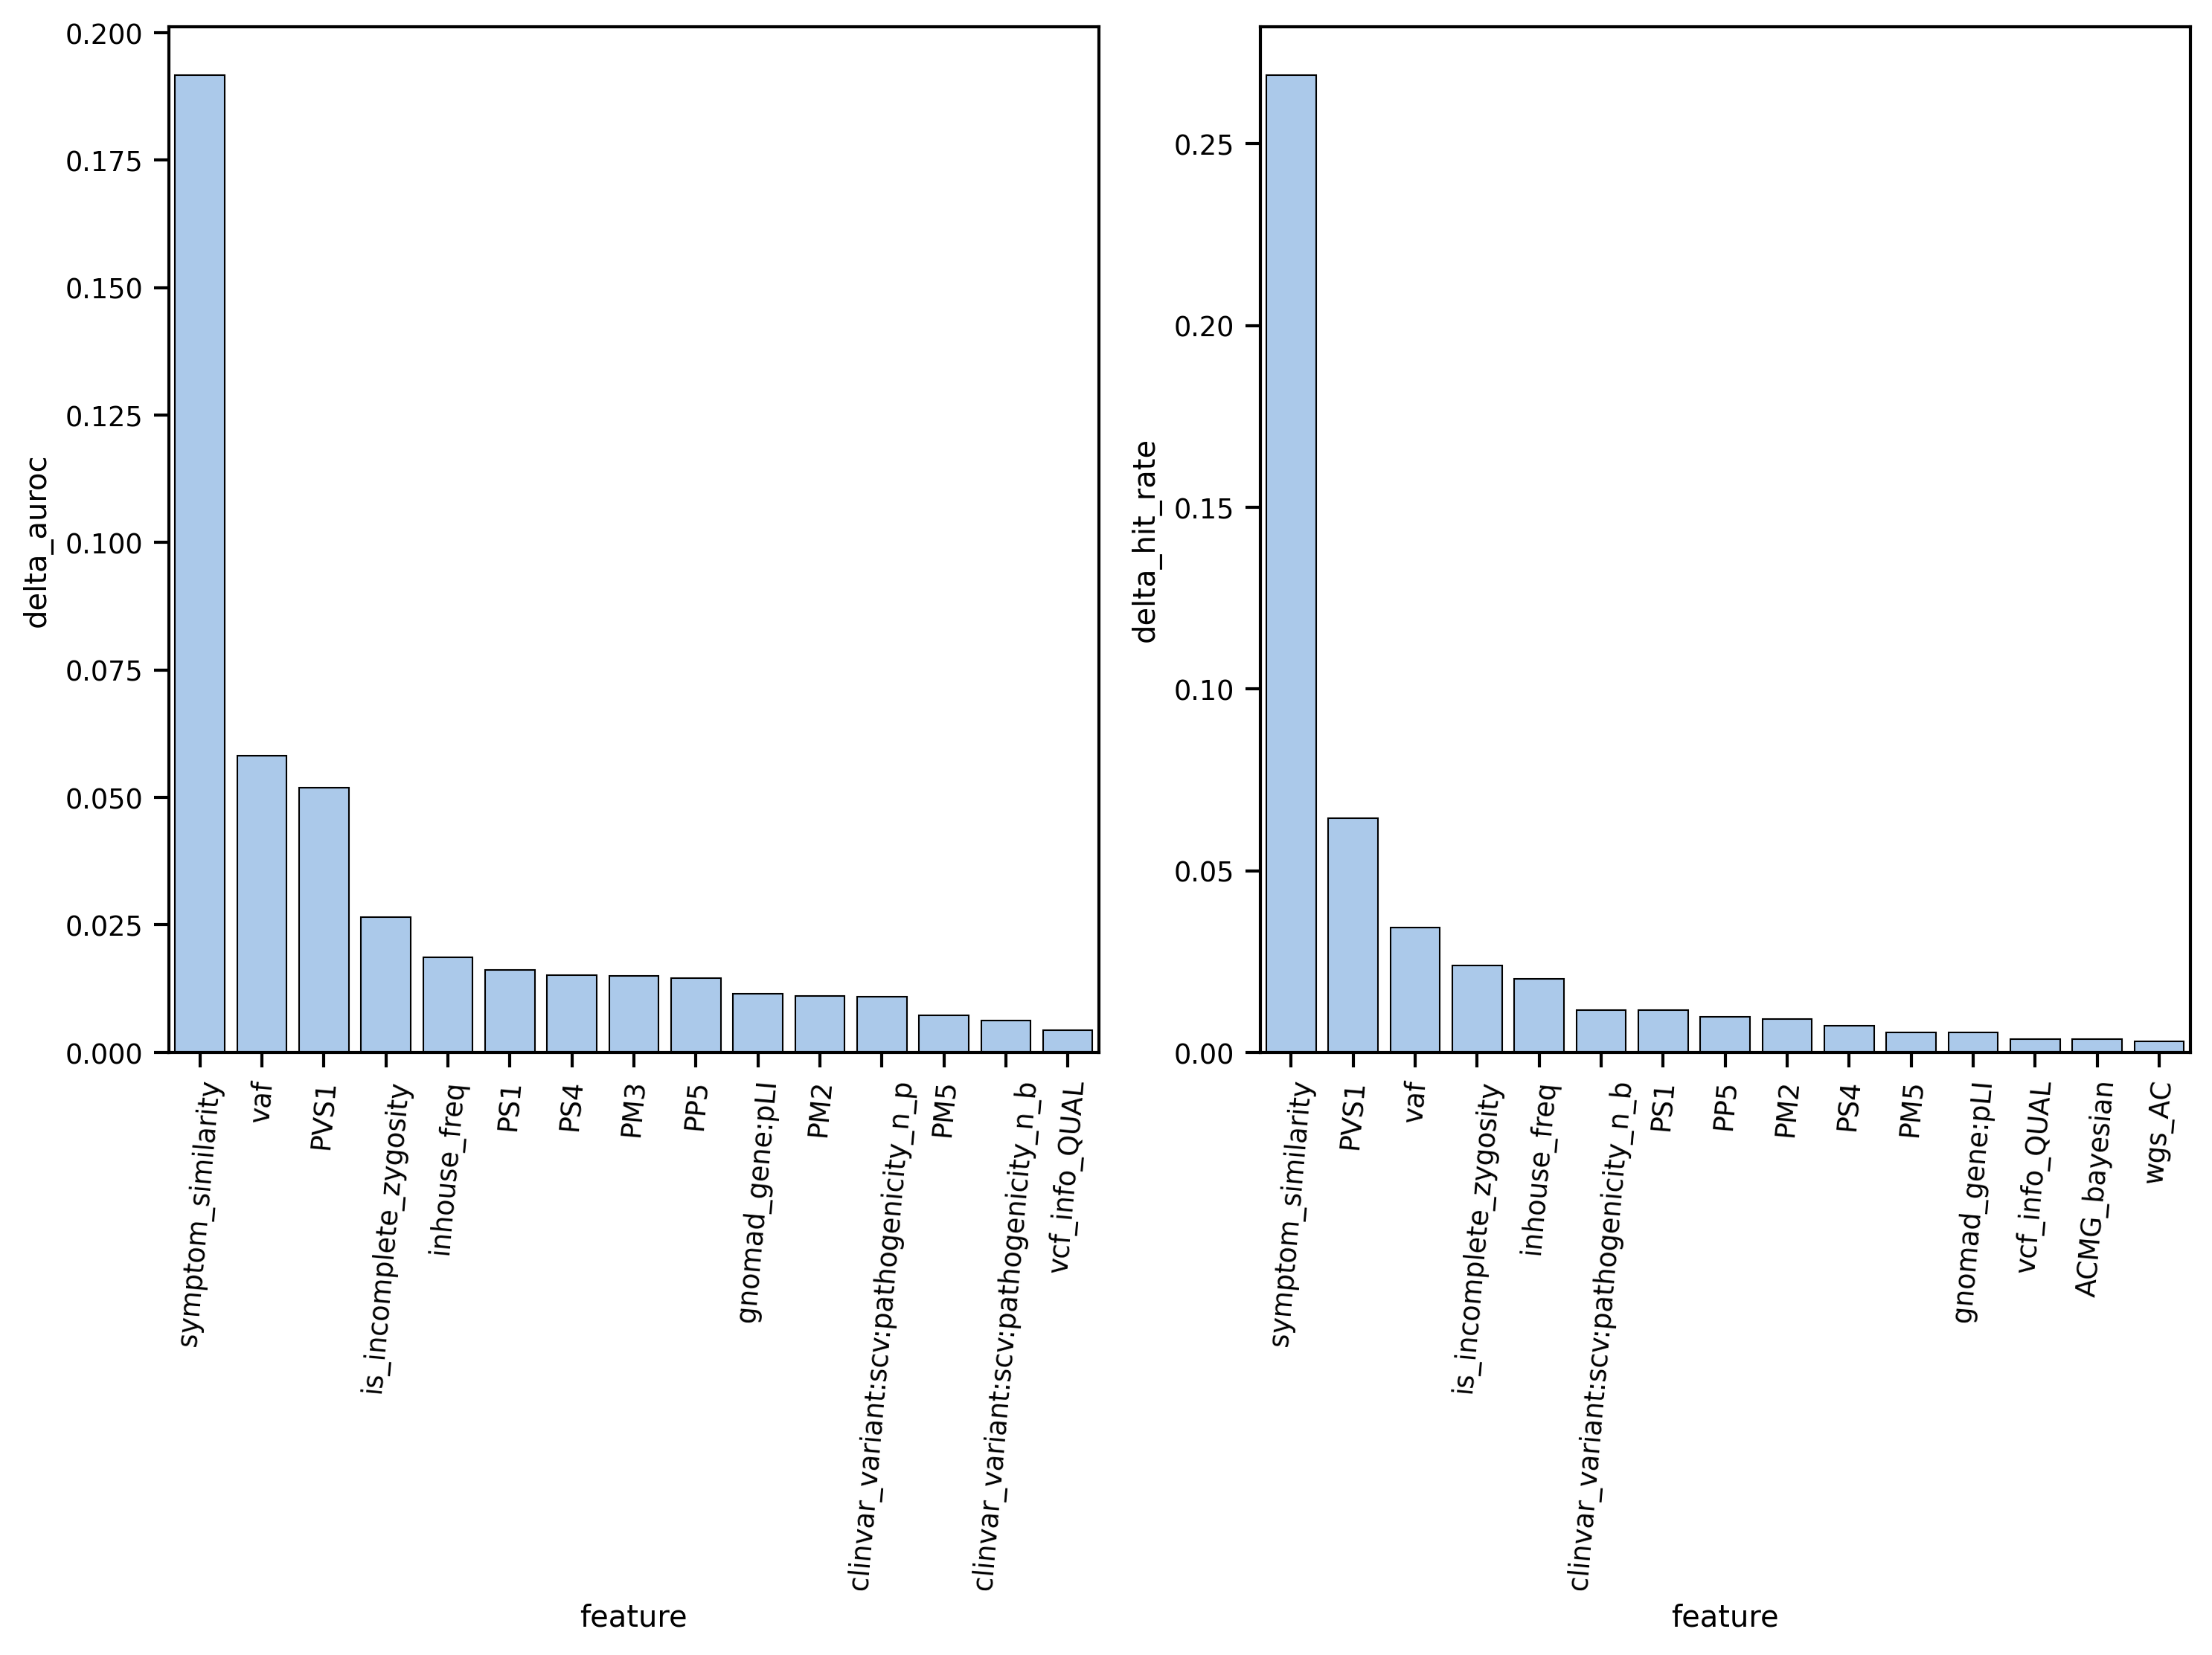

In [21]:
# 테이블 분리하기
from matplotlib import pyplot as plt
import pandas as pd
sns.set_context('paper')
sns.set_color_codes('pastel')

fig, axes= plt.subplots(1, 2, figsize=(10, 7.5), dpi=300)
res = pd.DataFrame([v for k, v in delta.items()], index=delta.keys(), columns=["delta_auroc", "delta_hit_rate"])
res.index.name = "feature"
res = res.reset_index()
sns.barplot(res.sort_values("delta_auroc", ascending=False).iloc[:15, :], x="feature", y="delta_auroc", color="b", edgecolor="black", linewidth=0.5, ax=axes[0])
sns.barplot(res.sort_values("delta_hit_rate", ascending=False).iloc[:15, :], x="feature", y="delta_hit_rate", color="b", edgecolor="black", linewidth=0.5, ax=axes[1])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=85)  # xticklabels와 rotation 설정
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=85)  # xticklabels와 rotation 설정
plt.tight_layout()
plt.savefig("figure4_feature_importance.png")

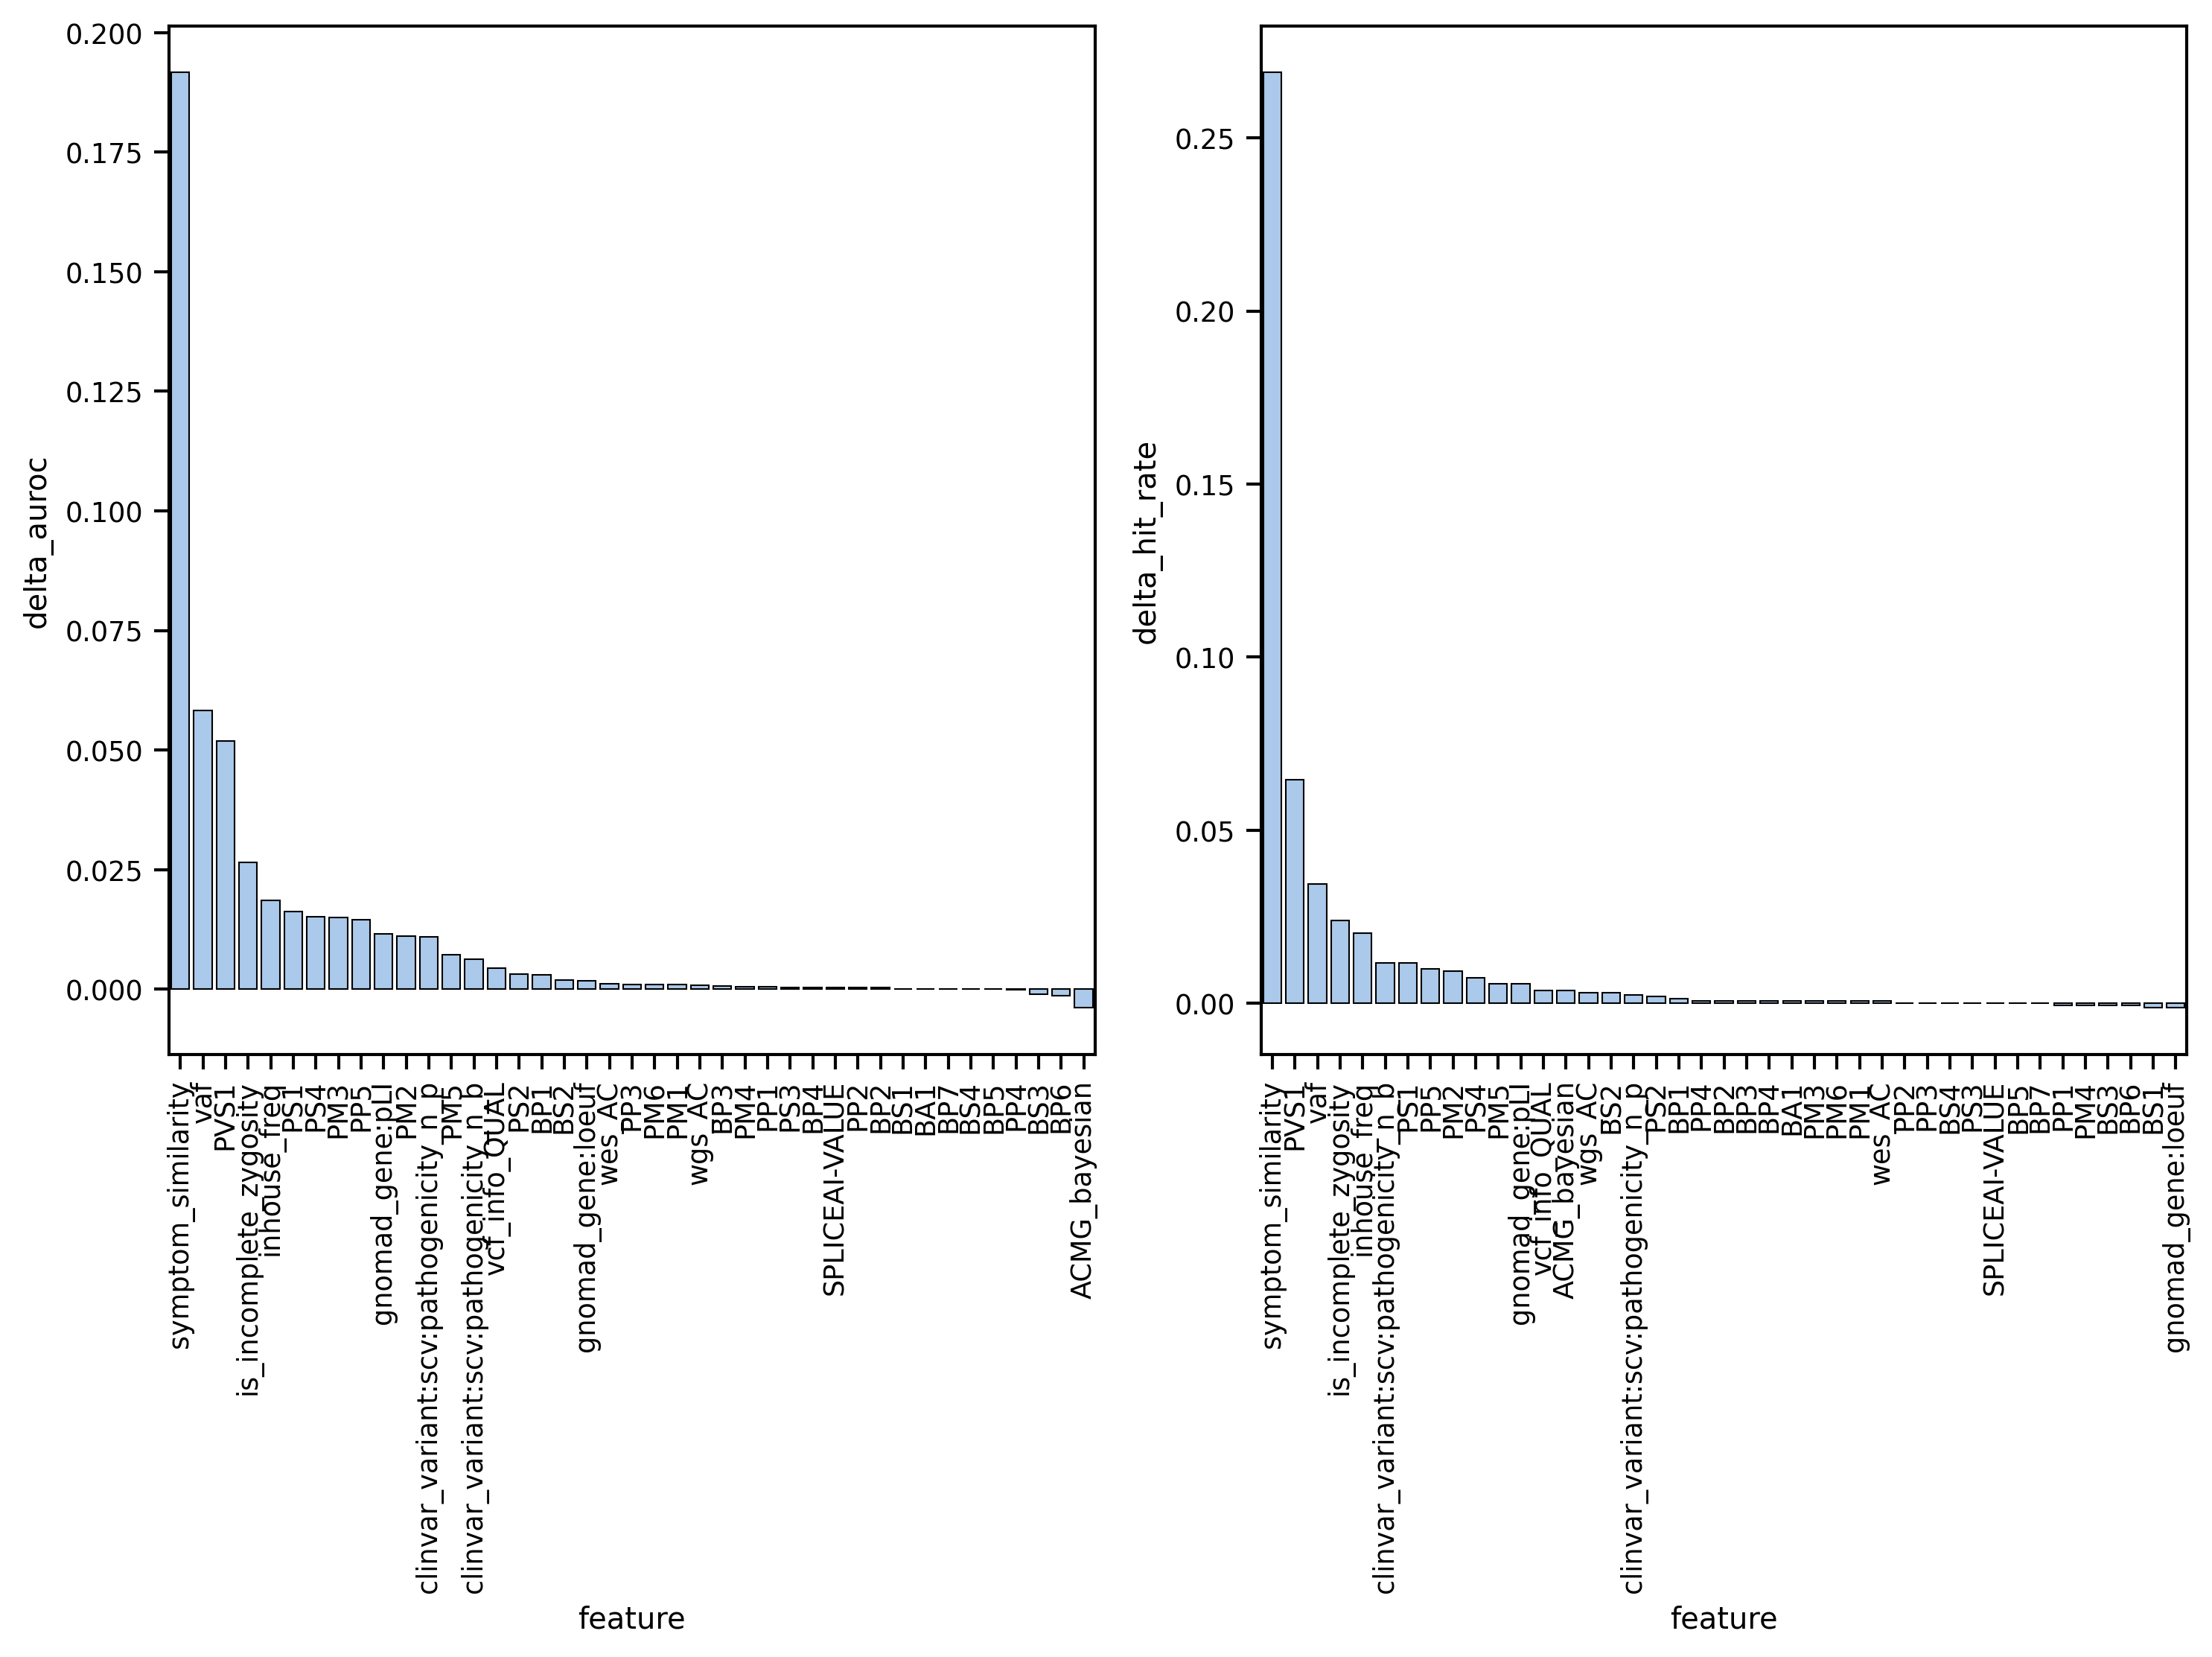

In [23]:
fig, axes= plt.subplots(1, 2, figsize=(10, 7.5), dpi=300)
res = pd.DataFrame([v for k, v in delta.items()], index=delta.keys(), columns=["delta_auroc", "delta_hit_rate"])
res.index.name = "feature"
res = res.reset_index()
sns.barplot(res.sort_values("delta_auroc", ascending=False), x="feature", y="delta_auroc", color="b", edgecolor="black", linewidth=0.5, ax=axes[0])
sns.barplot(res.sort_values("delta_hit_rate", ascending=False), x="feature", y="delta_hit_rate", color="b", edgecolor="black", linewidth=0.5, ax=axes[1])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  # xticklabels와 rotation 설정
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)  # xticklabels와 rotation 설정
plt.tight_layout()
plt.savefig("figure4_feature_importance_full.png")